**Задание 1:** Распределённое вычисление среднего значения и стандартного
отклонения
**Описание задачи:**
Напишите программу, которая выполняет следующие шаги:
1. Создайте массив случайных чисел на процессе с "rank = 0". Размер массива —
N (например, N = 10^6).
2. Разделите массив между всеми процессами с помощью функции
"MPI_Scatterv" (учитывая, что массив может не делиться нацело между
процессами).
3. Каждый процесс вычисляет:
 - Сумму элементов своей части массива.
 - Сумму квадратов элементов своей части массива.
4. Соберите локальные суммы на процессе с "rank = 0" с помощью функции
"MPI_Reduce".
5. На основе собранных данных вычислите:
 - Среднее значение массива.
 - Стандартное отклонение, формула:
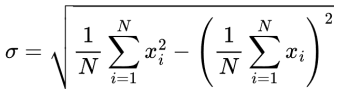
6. Выведите результаты на экран.

**Требования:**
- Используйте "MPI_Scatterv" для учёта остатка при разделении массива.
- Убедитесь, что программа работает корректно при любом количестве
процессов.

In [1]:
%%writefile program.cpp
#include <mpi.h>        // библиотека MPI
#include <iostream>     // ввод-вывод (cout)
#include <vector>       // контейнер vector
#include <random>       // генератор случайных чисел
#include <cmath>        // математические функции (sqrt)
#include <cstdlib>      // функции для работы с аргументами командной строки
#include <algorithm>    // std::max

int main(int argc, char** argv)            // точка входа в программу
{
    MPI_Init(&argc, &argv);                // инициализация MPI-среды

    int rank, size;                        // rank — номер процесса, size — количество процессов
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);  // получаем номер текущего процесса
    MPI_Comm_size(MPI_COMM_WORLD, &size);  // получаем общее количество процессов

    long long N = 1000000;                 // размер массива по умолчанию
    if (argc > 1)                          // если размер передали из командной строки
        N = atoll(argv[1]);                // считываем N

    double start_time = MPI_Wtime();       // старт замера времени выполнения

    long long base = N / size;             // базовое количество элементов на процесс
    long long rem  = N % size;             // остаток элементов
    long long local_n = base + (rank < rem ? 1 : 0); // сколько элементов получит текущий процесс

    std::vector<double> local_data(local_n); // локальный массив для каждого процесса
    std::vector<double> data;                // полный массив (только у rank 0)
    std::vector<int> sendcounts, displs;     // массивы для MPI_Scatterv

    if (rank == 0)                          // только процесс с rank 0 создаёт данные
    {
        data.resize(N);                     // выделяем память под массив N

        std::mt19937 gen(42);               // генератор случайных чисел
        std::uniform_real_distribution<double> dist(0.0, 1.0); // числа от 0 до 1

        for (long long i = 0; i < N; ++i)   // заполняем массив случайными числами
            data[i] = dist(gen);

        sendcounts.resize(size);            // сколько элементов отправлять каждому процессу
        displs.resize(size);                // смещения в массиве data

        long long offset = 0;               // текущее смещение
        for (int i = 0; i < size; ++i)      // для каждого процесса
        {
            sendcounts[i] = base + (i < rem ? 1 : 0); // размер блока
            displs[i] = offset;             // смещение начала блока
            offset += sendcounts[i];        // обновляем смещение
        }
    }

    MPI_Scatterv(                           // распределяем массив между процессами
        rank == 0 ? data.data() : nullptr,  // буфер отправки (только rank 0)
        rank == 0 ? sendcounts.data() : nullptr, // размеры блоков
        rank == 0 ? displs.data() : nullptr,     // смещения
        MPI_DOUBLE,                         // тип данных
        local_data.data(),                  // локальный буфер приёма
        local_n,                            // сколько элементов принимает процесс
        MPI_DOUBLE,                         // тип данных
        0,                                  // корневой процесс
        MPI_COMM_WORLD                     // коммуникатор
    );

    double local_sum = 0.0;                 // локальная сумма элементов
    double local_sumsq = 0.0;               // локальная сумма квадратов элементов

    for (long long i = 0; i < local_n; ++i) // каждый процесс обрабатывает свой кусок
    {
        local_sum += local_data[i];         // добавляем элемент в сумму
        local_sumsq += local_data[i] * local_data[i]; // добавляем квадрат элемента
    }

    double global_sum = 0.0;                // глобальная сумма элементов
    double global_sumsq = 0.0;              // глобальная сумма квадратов

    MPI_Reduce(&local_sum, &global_sum, 1, MPI_DOUBLE,
               MPI_SUM, 0, MPI_COMM_WORLD); // собираем сумму на rank 0

    MPI_Reduce(&local_sumsq, &global_sumsq, 1, MPI_DOUBLE,
               MPI_SUM, 0, MPI_COMM_WORLD); // собираем сумму квадратов на rank 0

    double end_time = MPI_Wtime();          // конец замера времени

    if (rank == 0)                          // вычисления и вывод только на rank 0
    {
        double mean = global_sum / N;       // среднее значение
        double variance = (global_sumsq / N) - mean * mean; // дисперсия
        double stddev = std::sqrt(std::max(0.0, variance)); // стандартное отклонение

        std::cout << "Mean = " << mean << std::endl;        // вывод среднего
        std::cout << "StdDev = " << stddev << std::endl;    // вывод стандартного отклонения
        std::cout << "Execution time: "
                  << end_time - start_time << " seconds\n"; // вывод времени
    }

    MPI_Finalize();                       // завершение работы MPI
    return 0;                             // завершение программы
}

Writing program.cpp


In [2]:
!mpic++ program.cpp -O2 -o program

In [5]:
!mpirun --allow-run-as-root --oversubscribe -np 4 ./program

Mean = 0.500055
StdDev = 0.288622
Execution time: 0.0702907 seconds


**Задание 2:** Распределённое решение системы линейных уравнений методом
Гаусса

**Описание задачи:**
Напишите программу для распределённого решения системы линейных
уравнений методом Гаусса:
1. Процесс с "rank = 0" создаёт матрицу коэффициентов A размером NxN и
вектор правых частей b.
2. Разделите строки матрицы между процессами с помощью функции
"MPI_Scatter".
3. Реализуйте следующие шаги метода Гаусса:
 - Прямой ход: каждый процесс выполняет вычитание строк для своей части
матрицы.
 - Обратный ход: соберите результаты на процессе с "rank = 0" и завершите
вычисления.
4. Выведите решение системы уравнений на экран.

**Требования:**
- Размеры матрицы должны быть заданы параметрами программы.
- Убедитесь, что программа работает корректно при любом количестве
процессов.
- Используйте "MPI_Bcast" для передачи текущей строки другим процессам во
время прямого хода.

In [6]:
%%writefile program2.cpp
// program2.cpp — Задание 2: MPI-метод Гаусса (распределённый прямой ход + сбор на rank 0)

#include <mpi.h>            // MPI
#include <iostream>         // cout
#include <vector>           // vector
#include <random>           // random
#include <cmath>            // fabs
#include <cstdlib>          // atoi
#include <algorithm>        // max

int main(int argc, char** argv)                                         // вход
{
    MPI_Init(&argc, &argv);                                             // старт MPI

    int rank = 0;                                                       // номер процесса
    int size = 0;                                                       // число процессов
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);                               // rank
    MPI_Comm_size(MPI_COMM_WORLD, &size);                               // size

    int N = 8;                                                          // размер по умолчанию
    if (argc >= 2) N = std::atoi(argv[1]);                              // N из аргументов

    if (N <= 0)                                                         // проверка
    {
        if (rank == 0) std::cout << "N должно быть > 0\n";               // сообщение
        MPI_Finalize();                                                 // конец MPI
        return 0;                                                       // выход
    }

    if (N % size != 0)                                                  // для Scatter нужен ровный делёж
    {
        if (rank == 0)
            std::cout << "Для MPI_Scatter в этом решении нужно N кратное числу процессов.\n"
                      << "Сейчас N=" << N << ", processes=" << size << ".\n"
                      << "Выбери N: 4,8,12,16,... или -np так, чтобы N % np == 0.\n";
        MPI_Finalize();                                                 // конец MPI
        return 0;                                                       // выход
    }

    MPI_Barrier(MPI_COMM_WORLD);                                        // синхронизация
    double start_time = MPI_Wtime();                                    // старт времени

    int local_rows = N / size;                                          // сколько строк у процесса
    int row_start = rank * local_rows;                                  // глобальный старт строки

    std::vector<double> A;                                              // полная матрица (только rank 0)
    std::vector<double> b;                                              // полный вектор b (только rank 0)

    std::vector<double> local_A(local_rows * N);                        // локальные строки матрицы
    std::vector<double> local_b(local_rows);                            // локальная часть b

    if (rank == 0)                                                      // создаём систему на rank 0
    {
        A.resize(N * N);                                                // A NxN
        b.resize(N);                                                    // b N

        std::mt19937 gen(42);                                           // генератор
        std::uniform_real_distribution<double> dist(0.0, 1.0);          // 0..1

        for (int i = 0; i < N; ++i)                                     // по строкам
        {
            double rowsum = 0.0;                                        // для диагонального усиления
            for (int j = 0; j < N; ++j)                                 // по столбцам
            {
                double v = dist(gen);                                   // случайное число
                A[i * N + j] = v;                                       // записали
                rowsum += std::fabs(v);                                 // сумма модулей
            }
            A[i * N + i] += rowsum + 1.0;                               // делаем диагональное преобладание
            b[i] = dist(gen);                                           // правая часть
        }
    }

    MPI_Scatter(                                                        // раздаём строки A
        rank == 0 ? A.data() : nullptr,                                  // отправка (rank 0)
        local_rows * N,                                                  // сколько отправлять
        MPI_DOUBLE,                                                     // тип
        local_A.data(),                                                  // куда принять
        local_rows * N,                                                  // сколько принять
        MPI_DOUBLE,                                                     // тип
        0,                                                               // root
        MPI_COMM_WORLD                                                   // мир
    );

    MPI_Scatter(                                                        // раздаём b по строкам
        rank == 0 ? b.data() : nullptr,                                  // отправка (rank 0)
        local_rows,                                                      // сколько отправлять
        MPI_DOUBLE,                                                      // тип
        local_b.data(),                                                  // куда принять
        local_rows,                                                      // сколько принять
        MPI_DOUBLE,                                                      // тип
        0,                                                               // root
        MPI_COMM_WORLD                                                   // мир
    );

    std::vector<double> pivot_row(N);                                    // буфер под текущую ведущую строку
    double pivot_b = 0.0;                                                // ведущий элемент b
    int pivot_owner = 0;                                                 // кто владелец pivot-строки

    for (int k = 0; k < N; ++k)                                          // прямой ход по столбцу k
    {
        pivot_owner = k / local_rows;                                    // какой процесс хранит строку k

        if (rank == pivot_owner)                                         // если я владелец pivot
        {
            int local_k = k - row_start;                                 // индекс k в локальных строках
            double diag = local_A[local_k * N + k];                      // диагональный элемент

            if (std::fabs(diag) < 1e-12)                                 // защита от деления на 0
                diag = (diag >= 0 ? 1e-12 : -1e-12);                     // подправили

            for (int j = 0; j < N; ++j)                                  // нормируем строку
                pivot_row[j] = local_A[local_k * N + j] / diag;          // делим на диагональ

            pivot_b = local_b[local_k] / diag;                           // нормируем b
        }

        MPI_Bcast(pivot_row.data(), N, MPI_DOUBLE, pivot_owner, MPI_COMM_WORLD); // рассылаем pivot-строку
        MPI_Bcast(&pivot_b, 1, MPI_DOUBLE, pivot_owner, MPI_COMM_WORLD);         // рассылаем pivot-b

        for (int i = 0; i < local_rows; ++i)                             // пробегаем по локальным строкам
        {
            int global_i = row_start + i;                                // глобальный индекс строки

            if (global_i <= k)                                           // выше или равные pivot не трогаем
                continue;                                                // пропуск

            double factor = local_A[i * N + k];                          // коэффициент вычитания

            if (std::fabs(factor) < 1e-18)                               // если почти 0
                continue;                                                // можно не вычитать

            for (int j = k; j < N; ++j)                                  // вычитаем по столбцам от k
                local_A[i * N + j] -= factor * pivot_row[j];             // A[i] = A[i] - factor * pivot

            local_b[i] -= factor * pivot_b;                              // b[i] = b[i] - factor * pivot_b

            local_A[i * N + k] = 0.0;                                    // явно обнуляем под диагональю
        }

        if (rank == pivot_owner)                                         // владельцу pivot обновим строку как нормированную
        {
            int local_k = k - row_start;                                 // локальный индекс
            for (int j = 0; j < N; ++j)                                  // записываем pivot-строку назад
                local_A[local_k * N + j] = pivot_row[j];                 // теперь диагональ = 1
            local_b[local_k] = pivot_b;                                  // и b
        }
    }

    std::vector<double> U;                                               // верхнетреугольная матрица (rank 0)
    std::vector<double> bb;                                              // преобразованный b (rank 0)

    if (rank == 0)                                                       // память только на root
    {
        U.resize(N * N);                                                 // U NxN
        bb.resize(N);                                                    // bb N
    }

    MPI_Gather(                                                          // собираем матрицу обратно на rank 0
        local_A.data(),                                                  // локальная часть
        local_rows * N,                                                  // сколько отправляем
        MPI_DOUBLE,                                                      // тип
        rank == 0 ? U.data() : nullptr,                                   // куда на root
        local_rows * N,                                                  // сколько принимает root с каждого
        MPI_DOUBLE,                                                      // тип
        0,                                                               // root
        MPI_COMM_WORLD                                                   // мир
    );

    MPI_Gather(                                                          // собираем b обратно
        local_b.data(),                                                  // локальная часть
        local_rows,                                                      // сколько отправляем
        MPI_DOUBLE,                                                      // тип
        rank == 0 ? bb.data() : nullptr,                                  // куда на root
        local_rows,                                                      // сколько принимает root
        MPI_DOUBLE,                                                      // тип
        0,                                                               // root
        MPI_COMM_WORLD                                                   // мир
    );

    std::vector<double> x;                                               // решение (rank 0)
    if (rank == 0)                                                       // обратный ход делаем на root
    {
        x.assign(N, 0.0);                                                // x = 0

        for (int i = N - 1; i >= 0; --i)                                 // от последней строки к первой
        {
            double sum = bb[i];                                          // начинаем с b
            for (int j = i + 1; j < N; ++j)                              // вычитаем известные части
                sum -= U[i * N + j] * x[j];                               // sum -= U[i][j] * x[j]
            x[i] = sum;                                                  // так как диагональ ~ 1 после нормировки
        }
    }

    MPI_Barrier(MPI_COMM_WORLD);                                         // синхронизация перед окончанием
    double end_time = MPI_Wtime();                                       // конец времени

    if (rank == 0)                                                       // вывод только на root
    {
        std::cout << "N = " << N << "\n";                                // печать N
        std::cout << "Processes = " << size << "\n";                     // печать процессов
        std::cout << "Solution x:\n";                                    // заголовок

        int to_print = std::min(N, 10);                                  // чтобы не печатать огромный вектор
        for (int i = 0; i < to_print; ++i)                               // печать первых элементов
            std::cout << "x[" << i << "] = " << x[i] << "\n";            // значение

        if (N > 10) std::cout << "... (показаны первые 10)\n";           // если большой N

        std::cout << "Execution time: " << (end_time - start_time)
                  << " seconds.\n";                                      // время
    }

    MPI_Finalize();                                                      // завершение MPI
    return 0;                                                            // выход
}

Writing program2.cpp


In [7]:
!mpic++ program2.cpp -O2 -o program2

In [8]:
!mpirun --allow-run-as-root --oversubscribe -np 4 ./program2 8

N = 8
Processes = 4
Solution x:
x[0] = 0.00189524
x[1] = -0.0551183
x[2] = 0.0776027
x[3] = 0.0387939
x[4] = -0.00271834
x[5] = 0.156427
x[6] = 0.05406
x[7] = 0.0588988
Execution time: 0.000577838 seconds.


**Задание 3:** Параллельный анализ графов (поиск кратчайших путей)

**Описание задачи:**
Напишите программу для параллельного поиска кратчайших путей в графе с
использованием алгоритма Флойда-Уоршелла:
1. Процесс с "rank = 0" создаёт матрицу смежности графа G размером NxN.
2. Разделите строки матрицы между процессами с помощью функции
"MPI_Scatter".
3. Реализуйте алгоритм Флойда-Уоршелла:
 - Каждый процесс обновляет свою часть матрицы для текущей итерации.
 - Передайте обновлённые данные между процессами с помощью функции
"MPI_Allgather".
4. После завершения всех итераций соберите матрицу на процессе с "rank = 0" и
выведите её на экран.

**Требования:**
- Размеры графа должны быть заданы параметрами программы.
- Убедитесь, что программа работает корректно при любом количестве
процессов.
- Используйте "MPI_Allgather" для обмена данными между процессами.

In [9]:
%%writefile program3.cpp

#include <mpi.h>                // MPI
#include <iostream>             // cout
#include <vector>               // vector
#include <random>               // random
#include <cstdlib>              // atoi
#include <algorithm>            // min

int main(int argc, char** argv)                                             // вход
{
    MPI_Init(&argc, &argv);                                                 // старт MPI

    int rank = 0;                                                           // номер процесса
    int size = 0;                                                           // число процессов
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);                                   // rank
    MPI_Comm_size(MPI_COMM_WORLD, &size);                                   // size

    int N = 8;                                                              // размер графа по умолчанию
    if (argc >= 2) N = std::atoi(argv[1]);                                  // N из аргументов

    if (N <= 0)                                                             // проверка
    {
        if (rank == 0) std::cout << "N должно быть > 0\n";                   // сообщение
        MPI_Finalize();                                                     // конец MPI
        return 0;                                                           // выход
    }

    if (N % size != 0)                                                      // Scatter требует ровный делёж
    {
        if (rank == 0)
            std::cout << "Нужно, чтобы N делилось на число процессов (MPI_Scatter).\n"
                      << "Сейчас N=" << N << ", processes=" << size << ".\n";
        MPI_Finalize();                                                     // конец MPI
        return 0;                                                           // выход
    }

    MPI_Barrier(MPI_COMM_WORLD);                                            // синхронизация
    double start_time = MPI_Wtime();                                        // старт времени

    const int INF = 1000000000;                                             // "бесконечность" (большое число)

    int local_rows = N / size;                                              // строк на процесс
    int row_start = rank * local_rows;                                      // стартовая строка в глобальной матрице

    std::vector<int> G;                                                     // полная матрица (только rank 0)
    std::vector<int> local_G(local_rows * N);                               // локальные строки матрицы

    if (rank == 0)                                                          // создаём граф на rank 0
    {
        G.resize(N * N);                                                    // NxN

        std::mt19937 gen(42);                                               // генератор
        std::uniform_int_distribution<int> wdist(1, 20);                    // веса ребёр 1..20
        std::uniform_int_distribution<int> edist(0, 99);                    // для вероятности ребра

        for (int i = 0; i < N; ++i)                                         // по строкам
        {
            for (int j = 0; j < N; ++j)                                     // по столбцам
            {
                if (i == j)                                                 // диагональ
                {
                    G[i * N + j] = 0;                                       // расстояние до себя 0
                }
                else
                {
                    int r = edist(gen);                                     // случайное число 0..99
                    if (r < 70)                                             // 70% что ребро есть
                        G[i * N + j] = wdist(gen);                          // вес ребра
                    else
                        G[i * N + j] = INF;                                 // ребра нет
                }
            }
        }
    }

    MPI_Scatter(                                                            // раздаём строки матрицы
        rank == 0 ? G.data() : nullptr,                                      // отправка
        local_rows * N,                                                     // сколько
        MPI_INT,                                                             // тип
        local_G.data(),                                                     // приём
        local_rows * N,                                                     // сколько
        MPI_INT,                                                             // тип
        0,                                                                   // root
        MPI_COMM_WORLD                                                      // мир
    );

    std::vector<int> full_G(N * N);                                          // буфер всей матрицы на каждом процессе

    MPI_Allgather(                                                          // соберём изначально всю матрицу на каждом
        local_G.data(),                                                     // локальные строки
        local_rows * N,                                                     // сколько отправляем
        MPI_INT,                                                             // тип
        full_G.data(),                                                      // куда собрать
        local_rows * N,                                                     // сколько принимаем от каждого
        MPI_INT,                                                             // тип
        MPI_COMM_WORLD                                                      // мир
    );

    for (int k = 0; k < N; ++k)                                              // основной цикл Флойда-Уоршелла
    {
        for (int i = 0; i < local_rows; ++i)                                 // только свои строки
        {
            int global_i = row_start + i;                                    // глобальный индекс строки

            int ik = local_G[i * N + k];                                     // dist(i,k) из локальной матрицы
            if (ik >= INF) continue;                                         // если бесконечность, смысла нет

            for (int j = 0; j < N; ++j)                                      // по всем столбцам
            {
                int kj = full_G[k * N + j];                                  // dist(k,j) из полной матрицы
                if (kj >= INF) continue;                                     // если бесконечность, пропуск

                int via = ik + kj;                                           // путь через k

                int& cur = local_G[i * N + j];                               // текущая dist(i,j) локально
                if (via < cur)                                               // если нашли короче
                    cur = via;                                               // обновляем
            }
        }

        MPI_Allgather(                                                      // обмен: обновлённые строки собрать в full_G
            local_G.data(),                                                  // отправляем свои строки
            local_rows * N,                                                  // сколько
            MPI_INT,                                                         // тип
            full_G.data(),                                                   // куда собрать
            local_rows * N,                                                  // сколько от каждого
            MPI_INT,                                                         // тип
            MPI_COMM_WORLD                                                   // мир
        );
    }

    std::vector<int> result;                                                 // итоговая матрица на root
    if (rank == 0) result.resize(N * N);                                     // выделяем память на root

    MPI_Gather(                                                              // соберём финальные строки на rank 0
        local_G.data(),                                                      // отправка
        local_rows * N,                                                      // сколько
        MPI_INT,                                                             // тип
        rank == 0 ? result.data() : nullptr,                                  // приём на root
        local_rows * N,                                                      // сколько от каждого
        MPI_INT,                                                             // тип
        0,                                                                   // root
        MPI_COMM_WORLD                                                      // мир
    );

    MPI_Barrier(MPI_COMM_WORLD);                                             // синхронизация
    double end_time = MPI_Wtime();                                           // конец времени

    if (rank == 0)                                                           // вывод на root
    {
        std::cout << "N = " << N << "\n";                                     // N
        std::cout << "Processes = " << size << "\n";                          // процессы
        std::cout << "Distance matrix (INF = no path):\n";                    // заголовок

        int limit = std::min(N, 12);                                          // ограничим печать для больших N
        for (int i = 0; i < limit; ++i)                                       // строки
        {
            for (int j = 0; j < limit; ++j)                                   // столбцы
            {
                int v = result[i * N + j];                                    // значение
                if (v >= INF/2) std::cout << "INF ";                          // если бесконечность
                else std::cout << v << " ";                                   // иначе число
            }
            if (N > limit) std::cout << "...";                                // если не всё показали
            std::cout << "\n";                                                // новая строка
        }
        if (N > limit) std::cout << "(показаны первые " << limit << "x" << limit << ")\n";

        std::cout << "Execution time: " << (end_time - start_time)
                  << " seconds.\n";                                           // время
    }

    MPI_Finalize();                                                          // конец MPI
    return 0;                                                                // выход
}

Writing program3.cpp


In [10]:
!mpic++ program3.cpp -O2 -o program3

In [11]:
!mpirun --allow-run-as-root --oversubscribe -np 4 ./program3 8

N = 8
Processes = 4
Distance matrix (INF = no path):
0 8 16 12 11 7 9 2 
10 0 21 13 14 1 18 8 
2 6 0 1 2 6 6 1 
1 5 8 0 1 6 5 2 
13 4 11 12 0 5 17 12 
10 1 21 14 15 0 17 7 
2 8 9 3 4 9 0 4 
14 6 14 15 9 5 12 0 
Execution time: 0.000134319 seconds.
